In [1]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

start_time = time.time()

with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)
    
# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

B_DF = DTBS_DataFrame['B'].copy()
C_DF = DTBS_DataFrame['C'].copy()
D_DF = DTBS_DataFrame['D'].copy()

In [24]:
df = A_DF[A_DF['date']=='2023-08-14']
output_df = pd.merge(df,B_DF[['bond_code','cat1','cat2','cn','sc','sn']],on='bond_code',how='left')

need_columns = ['date' ,'bond_code','cn','sn' ,'sc','dp', 'dl','cpr','bl','yl','ytm','trt','cat1','cat2']
output_df = output_df[output_df['ytm'] >= 0.5].copy()
output_df = output_df[need_columns].copy()


"""保存到EXCEL得时候重命名，便于阅读"""
column_mapping = {'date' : '日期',
                  'bond_code' : '可转债代码',
                  'dp' : '价格（收盘价全价）',
                  'cpr' : '转股溢价率',
                  'dl' : '双低',
                  'sn' : '正股名称',
                  'bl' : '债券余额（亿）',
                  'yl' : '剩余期限（年）',
                  'ytm' : '到期收益率', 
                  'trt' : '换手率', 
                  'cat1' : '申万一级', 
                  'cat2' : '申万二级',
                  'cn' : '转债名称',
                  'sc' : '正股代码'}

output_df.rename(columns=column_mapping,inplace=True)
output_df.to_excel('高ytm（大于0.5%）.xlsx',index=False)

In [7]:
start_day = '2023-01-01'
end_day = '2023-08-14'
set_which_day = 'mon'

# 这里设置的10000是无穷大的值，可以换成任意一个可转债不可能达到的价格，n为设置了几段价格区间
price_range = [(120,130), (130,140), (140,10000)]
output_title = ['120-130的转债平均收益率','130-140的转债平均收益率','140及以上的转债平均收益率']

n = len(price_range)
print(n)

day_list = list(D_DF[(start_day <= D_DF['date']) & (D_DF['date'] <= end_day) & (D_DF['which_day']==set_which_day)]['date'])
print(day_list)

df = A_DF[A_DF['date'].isin(day_list)].copy()

df.sort_values(by = ['bond_code','date'], inplace=True, ascending=[True,True])
df['lastweek_dp'] = df.groupby('bond_code')['dp'].shift(1)
df['change'] = df['dp'] / df['lastweek_dp'] - 1
print(df)

price_range_avg_change_list = []

for price_lower,price_upper in price_range:
    temp = df[(df['dp'] <= price_upper) & (df['dp'] >= price_lower)].groupby('date')['change'].mean()
    price_range_avg_change_list.append(list(temp))
    
print(price_range_avg_change_list)

3
['2023-01-09', '2023-01-16', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14']
                      bond_code        date      cpr       dp         bl  \
id                                                                         
110043.SH,2023-01-09  110043.SH  2023-01-09  16.0277  114.532  29.213300   
110043.SH,2023-01-16  110043.SH  2023-01-16  11.5574  116.899  29.213300   
110043.SH,2023-01-30  110043.SH  2023-01-30  12.6682  118.063  29.213300   
110043.SH,2023-02-06  110043.SH  2023-02-06  12.7621  116.500  29.213300   
110043.SH,2023-02-13  110043.SH  2023-02-13  15.4601  115.050  29.213300   
...                         ...         ...  

<Figure size 48000x18000 with 0 Axes>

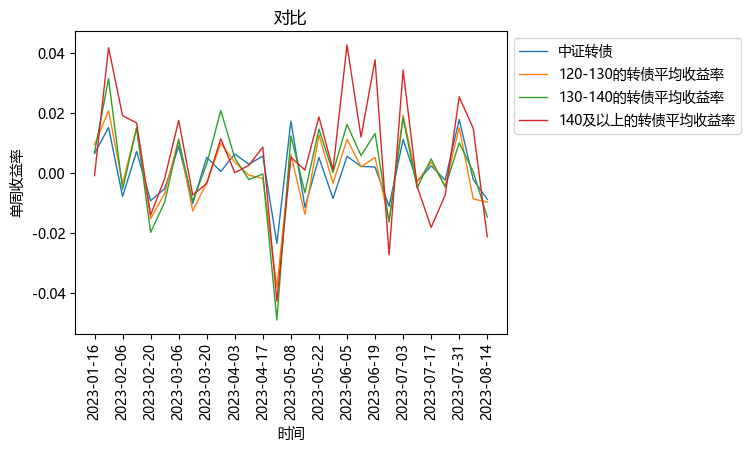

In [8]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

# 改变刻度
tick_spacing = 2

# 绘制单周净收益率曲线图
plt.figure(figsize=(40,15),dpi=1200)
fig, ax = plt.subplots(1, 1)

x = day_list[1:]

zi_weekly_index = list(C_DF[C_DF['date'].isin(day_list)]['zi'])
zi_weekly_return = [zi_weekly_index[i] / zi_weekly_index[i-1] - 1 for i in range(1,len(zi_weekly_index))]

plt.plot(x, zi_weekly_return, label="中证转债",linewidth=1)

for my_price_range in price_range:
    my_index = price_range.index(my_price_range)  
    plt.plot(x, price_range_avg_change_list[my_index][1:], label = output_title[my_index],linewidth=1)

plt.xlabel("时间")
plt.ylabel("单周收益率")
plt.title('对比')
# 图例显示
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# 设置打印的密度
# tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# 设置显示字体的大小
plt.tick_params(axis='both', labelsize=10)
# 对x轴进行翻转，竖向显示
plt.xticks(rotation=90, fontsize=10)

# 调整绘图区边距，确保图例和刻度完整显示
plt.subplots_adjust(right=0.8,bottom=0.25)

# 显示图像
plt.show()